# EECS 545 (WN 2024) Homework 4: Transfer Learning

<span class="instruction">Before starting the assignment, please fill in the following cell.</span>

In [61]:
###################################################################
# Enter your first and last name, e.g. "John Doe"                 #
# for example                                                     #
# __NAME__ = "Anthony Liu"                                        #
# __UNIQID__ = "anthliu"                                          #
###################################################################
# raise NotImplementedError("TODO: Add your implementation here.")
__NAME__ = "Yuzhou Chen"
__UNIQID__ = "yzc"
###################################################################
#                        END OF YOUR CODE                         #
###################################################################

print(f"Your name and email: {__NAME__} <{__UNIQID__}@umich.edu>")
assert __NAME__ and __UNIQID__

Your name and email: Yuzhou Chen <yzc@umich.edu>


# Transfer Learning
In this notebook, you will test your transfer learning implementation from `transfer_learning.py`

## Setup code
Before getting started, we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook. Let's start by checking whether we are using Python 3.10 or higher.

In [62]:
import sys
if sys.version_info[0] < 3:
    raise Exception("You must use Python 3")

if sys.version_info[1] < 11:
    print("Autograder will execute your code based on Python 3.11 environment. Please use Python 3.11 or higher to prevent any issues")
    print("You can create a conda environment with Python 3.11 like 'conda create --name eecs545 python=3.11'")
    raise Exception("Python 3 version is too low: {}".format(sys.version))
else:
    print("You are good to go")

You are good to go


First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Then, we run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [64]:
# install required libraries
# !pip install numpy==1.24.1 matplotlib==3.6.2 scikit-learn==1.2.0

# import libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# set figure size
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

Next, we need to make sure pytorch is installed. The following command will install pytorch if you haven't installed it before. Depending on your OS and GPU hardware, this may install a CPU or GPU version. If you want to use a GPU with PyTorch (which will exponentially speed up your computation time) you can follow the instructions on the pytorch [official website](https://pytorch.org/get-started/locally/). In this problem set a CPU-only pytorch is sufficient.

In [65]:
# uncomment and run the line below to install pytorch is you haven't done so
# !pip install torch torchvision

In [66]:
import torch
# check if CUDA is available on torch
print('PyTorch CUDA is available?', torch.cuda.is_available())

PyTorch CUDA is available? False


In [67]:
from IPython.display import display_html, HTML

display_html(HTML('''
<style type="text/css">
  .instruction { background-color: yellow; font-weight:bold; padding: 3px; }
</style>
'''));

Running the following cell allow us to import from `transfer_learning.py`. If it works correctly, it should print the message:
```Hello from transfer_learning.py```

In [68]:
from transfer_learning import hello
hello()

Hello from transfer_learning.py!


# Transfer Learning


## Downloading the dataset

We'll be doing some transfer learning on [hymenopteras](https://en.wikipedia.org/wiki/Hymenoptera). (Warning, lots of bugs!)

The dataset can be downloaded through [this link](https://drive.google.com/file/d/1cGz3dhKMv1DFeRMCjBpRLyCQuR7HP_vd/view?usp=sharing) (45Mb) and unzip the folder into the data directory.

```
HW4 /
--| transfer_learning.ipynb
--| data /
----| hymenoptera_data /
------| train /
------| ...
```

## Loading and visualizing the data

In [69]:
import os
from torchvision import datasets, transforms

# Load data from disk
data_dir = './data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x))
                  for x in ['train', 'val']}

In [70]:
# visualize grid
def make_grid(ims, h, w, captions=None):
    for i in range(h):
        for j in range(w):
            if ims[i*w + j] is None:
                continue
            plt.subplot(h, w, i*w + j + 1)
            plt.axis('off')
            plt.imshow(ims[i*w + j])
            if captions is not None and captions[i*w + j] is not None:
                plt.title(captions[i*w + j])

In [71]:
# sample images from image_datasets
sample_size = 25
rng = np.random.default_rng(545)
idxs = {x: rng.choice(len(image_datasets[x]), sample_size, replace=False)
        for x in ['train', 'val']}
samples = {x: [image_datasets[x][i][0] for i in idxs[x]]
           for x in ['train', 'val']}
sample_classes = {x: [image_datasets[x].classes[image_datasets[x][i][1]] for i in idxs[x]]
                  for x in ['train', 'val']}

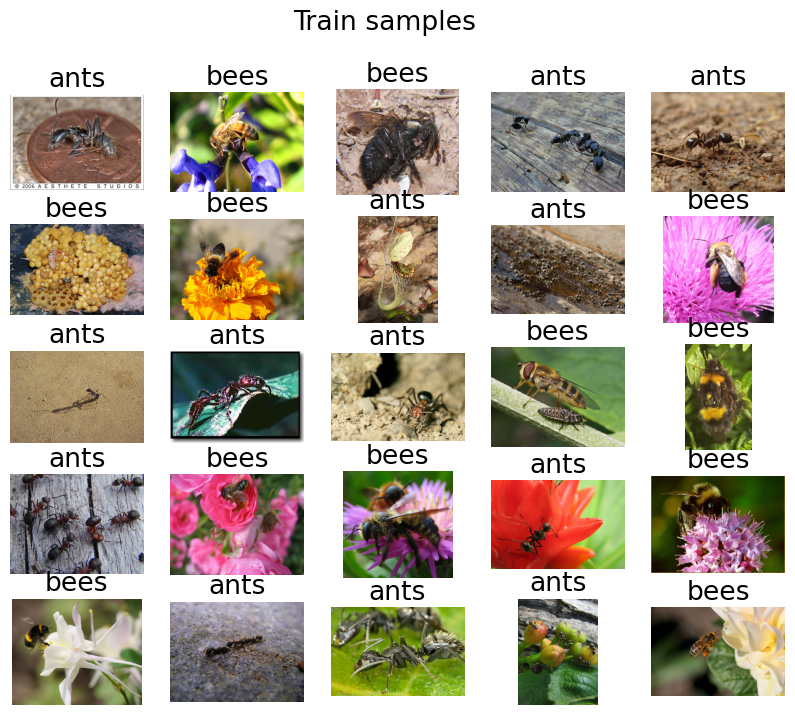

In [72]:
plt.suptitle('Train samples')
make_grid(samples['train'], sample_size // 5, 5, sample_classes['train'])

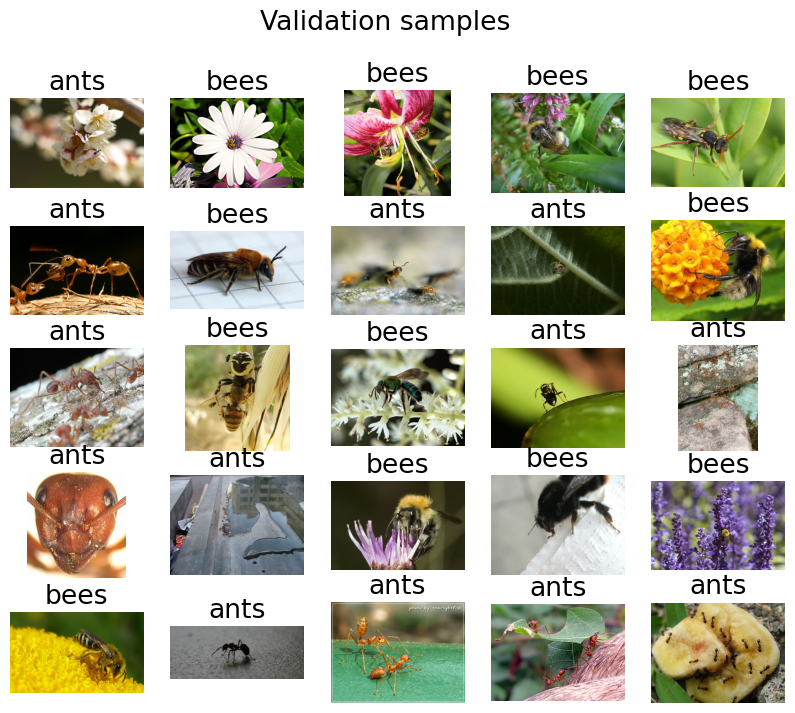

In [73]:
plt.suptitle('Validation samples')
make_grid(samples['val'], sample_size // 5, 5, sample_classes['val'])

## Preprocessing images

Before we can start training with these images, we need to make sure
1. The image sizes are correct (224 x 224) images
2. The images are normalized to the mean and standard deviation in each channel. Normalization will almost always improve NN performance by removing scaling patterns in the input data.
In addition, since we are transfer learning on an *ImageNet model*, we need to apply the same normalization as applied in the original model. This is: normalized = (image - mu) / std, where mu = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
These were are the mean and standard deviations of each channel in the ImageNet dataset.

In addtion, we can apply some image augmentations to the training data. E.g. we can randomly crop and randomly flip the training images. This way, we can artificially learn on more training data and improve performance!

We can visualize some of these transformations as follows, for which pytorch gives some convenient functions.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


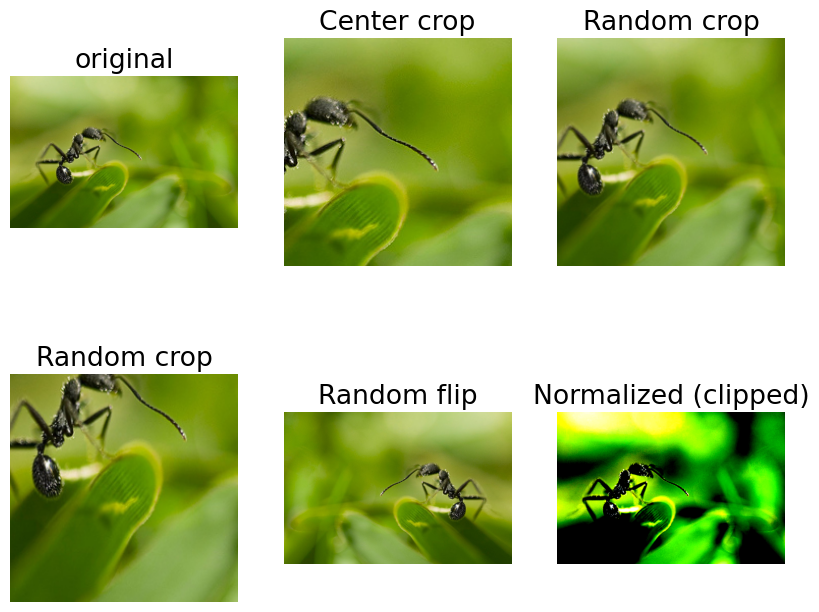

In [74]:
im = image_datasets['train'][7][0]
grid = [
    im,
    transforms.CenterCrop(224)(im),
    transforms.RandomResizedCrop(224)(im),
    transforms.RandomResizedCrop(224)(im),
    transforms.RandomHorizontalFlip()(im),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(transforms.ToTensor()(im)).permute(1, 2, 0),
]
caps = [
    'original',
    'Center crop',
    'Random crop',
    'Random crop',
    'Random flip',
    'Normalized (clipped)',
]
make_grid(grid, h=2, w=3, captions=caps)

## Putting everything together

<span class="instruction">Complete the missing code segments in `transfer_learning.py` marked by the TODOs.</span>

In [75]:
import os
from torchvision import datasets, transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load data from disk
data_dir = './data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
               shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

Set the device to CUDA if it's available, otherwise we'll use CPU.

In [76]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Finetune the pre-trained model

*Warning:* If you are training on CPU, this may take some time (up to a few hours).
To give you an idea of whether your code is working or not, our instructor solution gets around ~65%, ~75% and 80% after 1, 2, and 3 epochs.
These numbers are not exact and may fluctuate due to randomization.

In [77]:
from transfer_learning import finetune

NUM_EPOCHS = 5# Feel free to train more epochs if you have time
model_ft = finetune(device, dataloaders, dataset_sizes, class_names, num_epochs=NUM_EPOCHS)

Performance of pre-trained model without finetuning
Training complete in 0m 24s
Best val Acc: 0.228758
Finetune the model
Epoch 0/4
----------
train Loss: 0.7378 Acc: 0.6270
val Loss: 0.5053 Acc: 0.8235
Epoch 1/4
----------
train Loss: 0.5288 Acc: 0.7910
val Loss: 0.3029 Acc: 0.8954
Epoch 2/4
----------
train Loss: 0.4329 Acc: 0.8197
val Loss: 0.2351 Acc: 0.9020
Epoch 3/4
----------
train Loss: 0.5804 Acc: 0.7910
val Loss: 0.3698 Acc: 0.8954
Epoch 4/4
----------
train Loss: 0.3717 Acc: 0.8648
val Loss: 0.3898 Acc: 0.8627
Training complete in 4m 49s
Best val Acc: 0.901961


In [78]:
mu = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
unnormalize = lambda t: t.permute(1, 2, 0) * std + mu

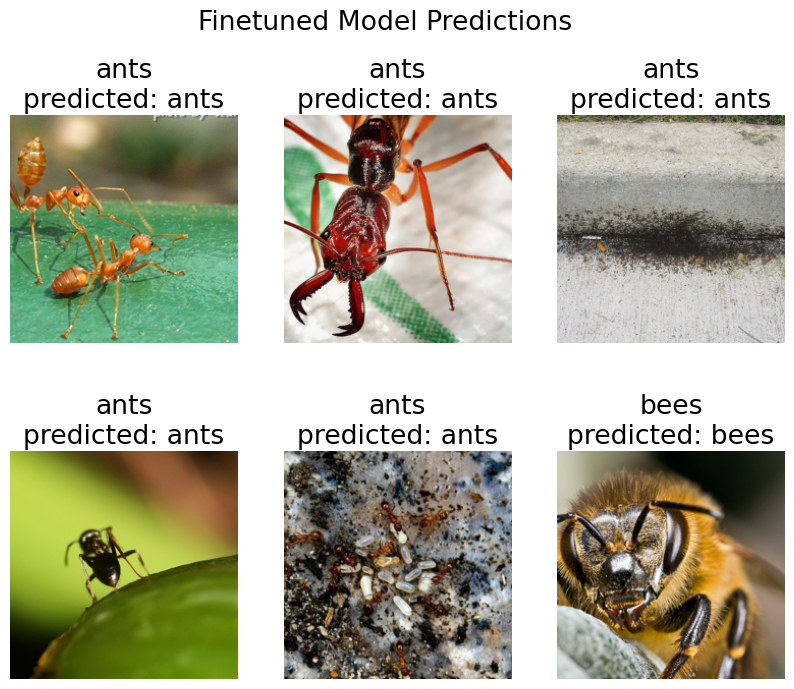

In [79]:
from transfer_learning import visualize_model

num_images = 6
tensors, captions = visualize_model(device, dataloaders, model_ft, class_names, num_images=num_images)
images = [unnormalize(t) for t in tensors]
plt.suptitle('Finetuned Model Predictions')
make_grid(images, h=num_images // 3, w=3, captions=captions)

## Freeze the parameters in pre-trained model and train the final fc layer
*Warning:* If you are training on CPU, this may take some time (up to a few hours).
To give you an idea of whether your code is working or not, our instructor solution gets around ~65%, ~75% and 80% after 1, 2, and 3 epochs.
These numbers are not exact and may fluctuate due to randomization.

In [80]:
from transfer_learning import freeze

NUM_EPOCHS = 5# Feel free to train with more epochs if you have time
model_conv = freeze(device, dataloaders, dataset_sizes, class_names, num_epochs=NUM_EPOCHS)

Performance of pre-trained model without finetuning
Training complete in 0m 24s
Best val Acc: 0.503268
Finetune the model
Epoch 0/4
----------
train Loss: 0.5851 Acc: 0.6926
val Loss: 0.2236 Acc: 0.9281
Epoch 1/4
----------
train Loss: 0.4226 Acc: 0.8074
val Loss: 0.3280 Acc: 0.8497
Epoch 2/4
----------
train Loss: 0.4647 Acc: 0.7992
val Loss: 0.1961 Acc: 0.9412
Epoch 3/4
----------
train Loss: 0.4751 Acc: 0.8033
val Loss: 0.1948 Acc: 0.9346
Epoch 4/4
----------
train Loss: 0.4097 Acc: 0.8320
val Loss: 0.2433 Acc: 0.9281
Training complete in 4m 12s
Best val Acc: 0.941176


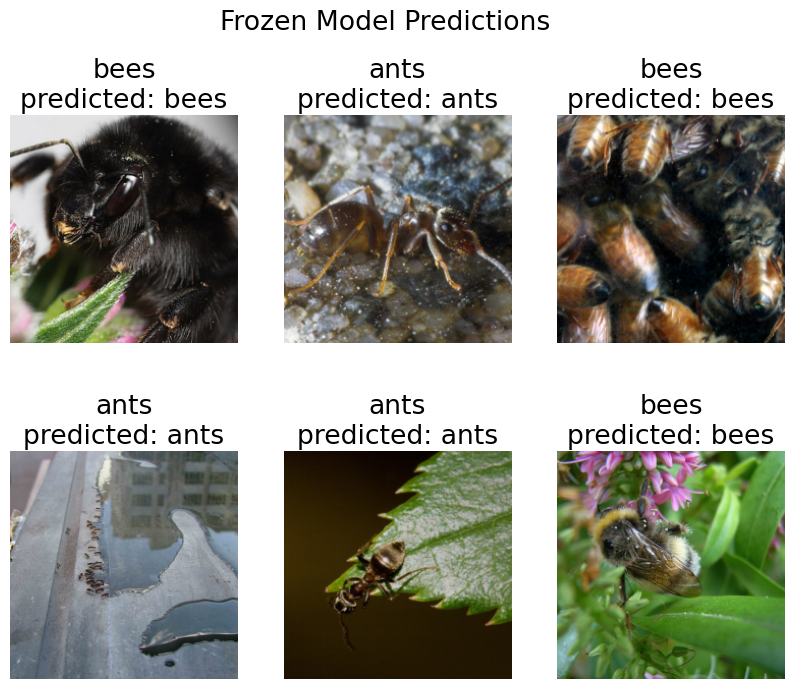

In [81]:
num_images = 6
tensors, captions = visualize_model(device, dataloaders, model_conv, class_names, num_images=num_images)
images = [unnormalize(t) for t in tensors]
plt.suptitle('Frozen Model Predictions')
make_grid(images, h=num_images // 3, w=3, captions=captions)

How did you do? Report the accuracy on the validation dataset for both the finetuned and frozen scenarios in your final report.